# QiskitとQuri-Partsを用いたグラフ彩色問題に対する量子交互演算子アンザッツ

このチュートリアルでは、量子近似最適化アルゴリズム（QAOA）および量子交互演算子アンザッツ（Quantum Alternating Operator Ansatz）を用いてグラフ彩色問題を解きながら、それぞれの機能について説明する。今回は、QiskitとQuri-Partsを用いてシミュレーションを行う。


In [1]:
from typing import Sequence

import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import qiskit.primitives as qk_pr
import scipy.optimize as opt

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.qiskit import QiskitTranspiler
from qamomile.quri_parts import QuriPartsTranspiler

## 数理モデルの構築
まず、JijModeling を用いてグラフ彩色問題の数学モデルを実装する。

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # 変数を定義する
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # 問題を設定する
    problem = jm.Problem("Graph Coloring")
    # 各頂点がただ一つの色を持つようにワンホット制約を設定する

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # 目的関数の設定：辺で接続された頂点が同じ色である場合の辺の数を最小化する
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

## インスタンスデータの準備
次に、問題のインスタンスを作成する。

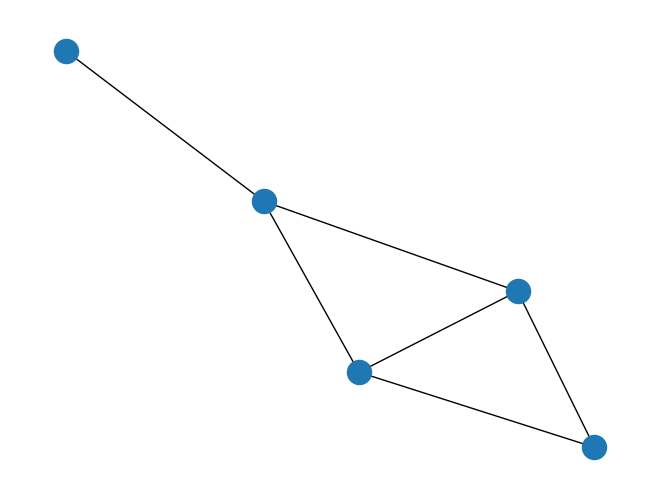

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [4]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

## 量子近似最適化アルゴリズム（QAOA）

量子近似最適化アルゴリズム（Quantum Approximate Optimization Algorithm：QAOA）は、変分量子回路を用いる量子最適化アルゴリズムの一つである。詳細な説明は文献[1]を参照してほしいが、ここではその概要のみを紹介する。

QAOAでは、イジングハミルトニアン $H_P = \sum_{ij}J_{ij}Z_iZ_j$ と $X$ ミキサーハミルトニアン $H_M = \sum_iX_i$ を用いて、以下のように変分量子回路を構成する：

初期状態 $\ket{\psi_0}$ から始めて、

$$
\ket{\psi(\beta,\gamma)} = e^{-i\beta_pH_M}e^{-i\gamma_pH_P}\cdots e^{-i\beta_1H_M}e^{-i\gamma_1H_P}\ket{\psi_0}
$$

のように記述できる。ここで、$\beta_k, \gamma_k$ は最適化すべきパラメータであり、操作 $e^{-\beta_kH_M}e^{-\gamma_kH_P}$ を $p$ 回繰り返すため、全体のパラメータ数は $2p$ 個となる。標準的なQAOAにおいて、パラメータの数は量子ビット数には依存せず、繰り返し回数 $p$ のみに依存する。

$\beta_k, \gamma_k$ の最適化は、以下の2ステップを繰り返すことで行われる：

1. 量子デバイス上で期待値 $\bra{\psi(\beta,\gamma)}H_P\ket{\psi(\beta,\gamma)}$ を計算する。
2. 古典コンピュータ上でこの期待値を最小化するようにパラメータを更新する。

量子コンピュータでの期待値の計算と古典コンピュータでのパラメータ最適化を繰り返すことで、最小エネルギー $\langle H_P \rangle$ とそれに対応する最終状態が得られる。QAOA を数理最適化アルゴリズムとして捉えると、この最小エネルギーは目的関数の最小値に対応し、最終状態が最適解に対応する。

### Qamomile を使った QAOA の実装

それでは、QAOAを用いてグラフ彩色問題を解いてみよう。QAOAを実行するためには、数学モデルをイジングハミルトニアンに変換し、量子コンピューティングライブラリを使って変分量子回路とハミルトニアンを作成する必要がある。しかし、QamomileはQAOAをサポートしているため、比較的簡単に実行することができる。

まず、JijModeling-Transpilerを用いて、JijModelingの数学モデルとインスタンスデータから `CompiledInstance` を作成する。

In [5]:
compiled_instance = jmt.compile_model(problem, instance_data)

次に、QAOAConverterを作成する。このコンバーターに制約条件の重みを設定することで、ハミルトニアンを作成することができる。

In [6]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode(multipliers={"one-color": 1})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

### QAOA回路の可視化

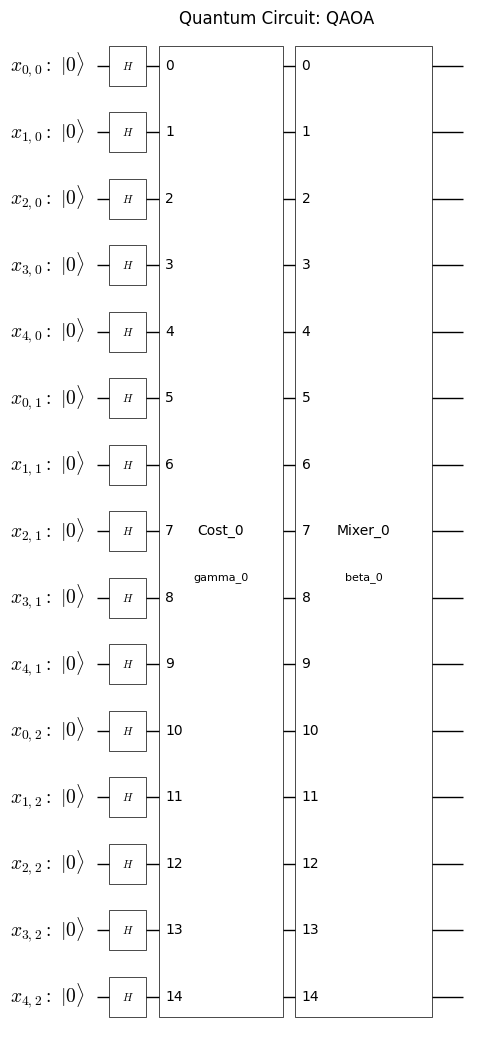

In [7]:
plot_quantum_circuit(qaoa_circuit)

### Qiskitを使ってQAOAを実行する

変分量子回路とハミルトニアンの準備が整ったので、実際にQiskitを用いてQAOAを実行してみよう。Qamomileの回路をQiskitの回路に変換し、シミュレーションを実行する。

In [8]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

In [9]:
# 変分ステップ
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 100})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.646036208250357
       x: [-4.546e-01  3.550e-01]
    nfev: 46
   maxcv: 0.0

### 結果の可視化

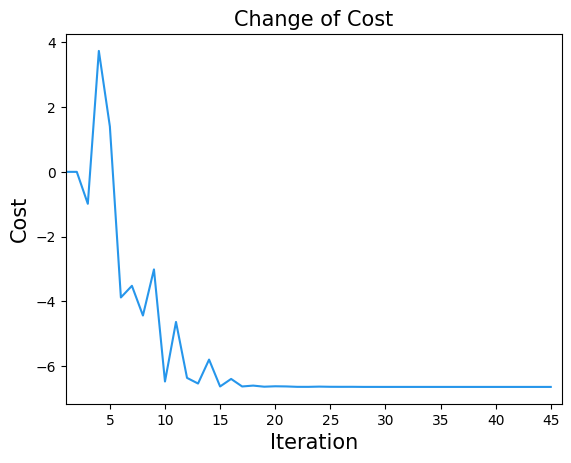

In [10]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

## 量子交互演算子アンザッツ

次に、量子交互演算子アンザッツを用いてグラフ彩色問題を解いてみよう。量子交互演算子アンザッツ（Quantum Alternating Operator Ansatz）[2]はQAOAを改良したもので、ミキサーを $X$ ミキサーから問題に特化したミキサーに変更することで、制約を満たす解のみを探索できるようにしている。詳細については原論文を参照してほしい。ここでは、JTQにおける実装方法を紹介する。

グラフ彩色問題では、以下のようなワンホット制約がある：

$$
\sum_k x_{v,k} = 1\quad \forall v
$$

この制約を $XY$ ミキサーに変換して扱うのが、グラフ彩色問題に対する量子交互演算子アンザッツのアプローチである。

### Qamomileを使った量子交互演算子アンザッツの実装

In [11]:
gamma_1 = qm.circuit.Parameter("gamma_1")
# 単色ペナルティを削除する。
qaoa_converter.ising_encode(multipliers={"one-color": 0.0})
# ミキサー回路なしで exp(-i gamma H_P) 回路を取得する。  
qaoa_cost_circuit = qaoa_converter.get_cost_ansatz(gamma_1)

次に、$XY$ ミキサーを作成する。$XY$ ミキサーは以下のように表される：

$$
XY_{ij} = \frac{1}{2}\left(X_iX_j + Y_iY_j \right).
$$

この演算子は、ビット $i, j$ の 1 と 0 を入れ替えるものである。そのため、ワンホット制約を満たすビット列 $100$ を、同じく制約を満たす $010$ に変換することができる。ここで、ワンホット制約が関係するのは色に関する部分のみである。したがって、数学モデルにおいては $x_{v0}$ と $x_{v1}$ の間のビットを変換する必要がある。一方で、これらの変数は通常量子ビットに埋め込まれているため、アルゴリズムを構築する際には、どのビットがどの変数に対応しているのかを把握し、適切に扱う必要がある。

JTQでは、この変数と量子ビットの対応関係が `CompiledInstance` の中の `var_map` に含まれている。

```python
var_map['variable_name'][indices]
```
このようにして、数学モデル中の変数がどの量子ビットに対応しているかを確認できる。

この仕組みを用いて $XY$ ミキサーを作成しよう。

ここで必要となるのは、$x_{v,k}$ と $x_{v,k+1}$ の間の変換であるため、対応する量子ビットのインデックスは compiled_instance.var_map.var_map["x"][(i,k)] にアクセスすることで取得できる。

In [12]:
def create_xy_mixer(
    beta: qm.circuit.Parameter,
    num_nodes: int,
    num_color: int,
    compiled_instance: jmt.CompiledInstance,
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n, name="XY-mixer")
    var_map = compiled_instance.var_map.var_map["x"]
    # 偶数
    for i in range(num_nodes):
        for k in range(0, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # 奇数
    for i in range(num_nodes):
        for k in range(1, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # 初期-最終
    if num_color % 2 == 1:
        for i in range(num_nodes):
            qc.rxx(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
            qc.ryy(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
    return qc

In [13]:
def create_initial_state(
    compiled_instance: jmt.CompiledInstance, num_nodes: int, num_color: int
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n)
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        qc.x(var_map[(i, 0)])  # set all nodes to color 0
    return qc

### 量子交互演算子アンザッツ回路の可視化
アンザッツの作成が完了したので、量子交互演算子アンザッツを実行してみよう。

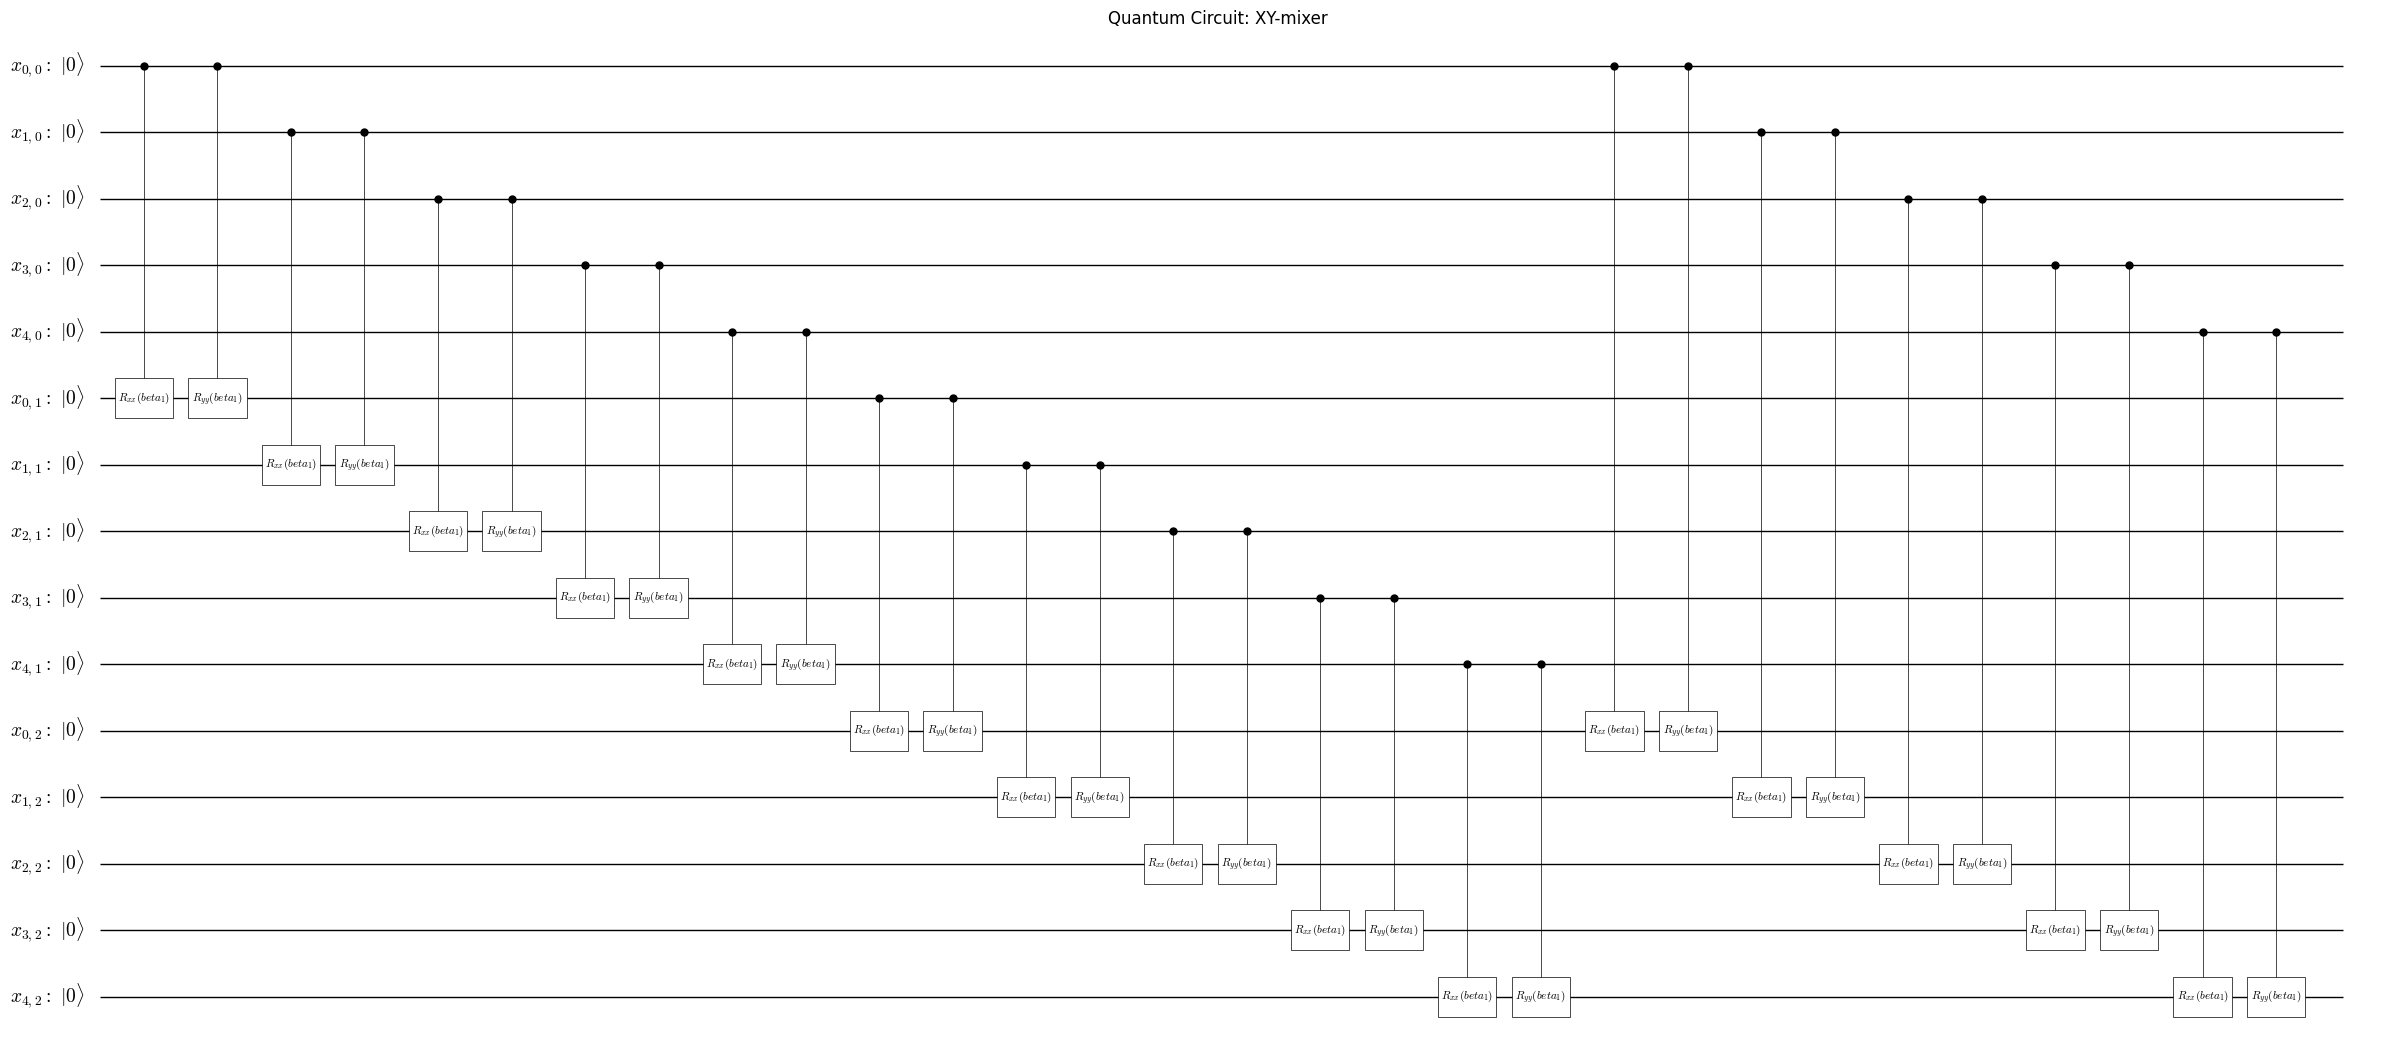

In [14]:
initial_circuit = create_initial_state(compiled_instance, num_nodes, color_num)
initial_circuit.update_qubits_label(qaoa_converter.int2varlabel)
beta_1 = qm.circuit.Parameter("beta_1")
mixer_circuit = create_xy_mixer(beta_1, num_nodes, color_num, compiled_instance)
mixer_circuit.update_qubits_label(qaoa_converter.int2varlabel)
plot_quantum_circuit(mixer_circuit)

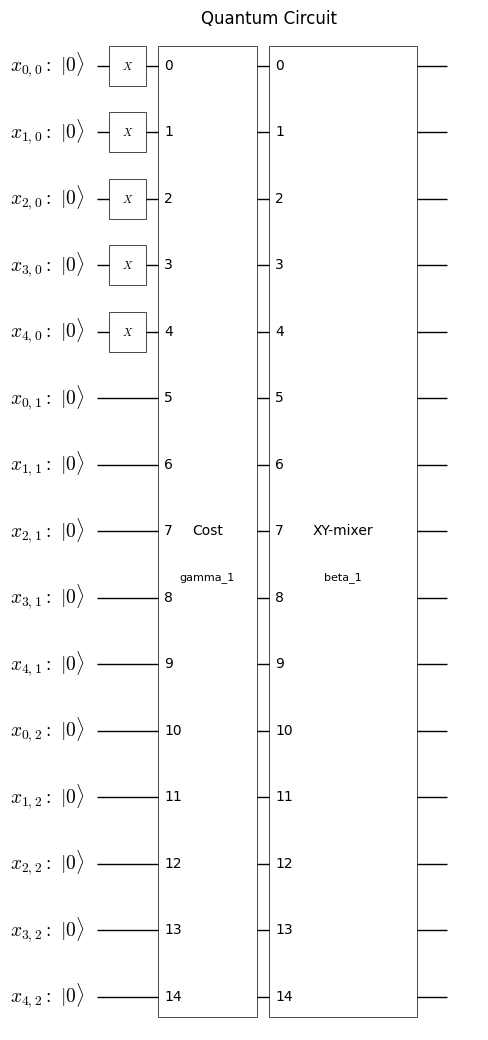

In [15]:
initial_circuit.append(qaoa_cost_circuit)
initial_circuit.append(mixer_circuit)

alternating_ansatz = initial_circuit

plot_quantum_circuit(alternating_ansatz)

### Qiskit を用いた量子交互演算子アンザッツの実行

In [16]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(alternating_ansatz)

In [17]:
# 変分ステップ
estimator = qk_pr.StatevectorEstimator()

cost_history = []

def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data["evs"]
    cost_history.append(cost)
    return cost


result = opt.minimize(
    estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 100}
)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.43749997649938
       x: [ 7.855e-01 -1.425e-01]
    nfev: 31
   maxcv: 0.0

### 結果の可視化

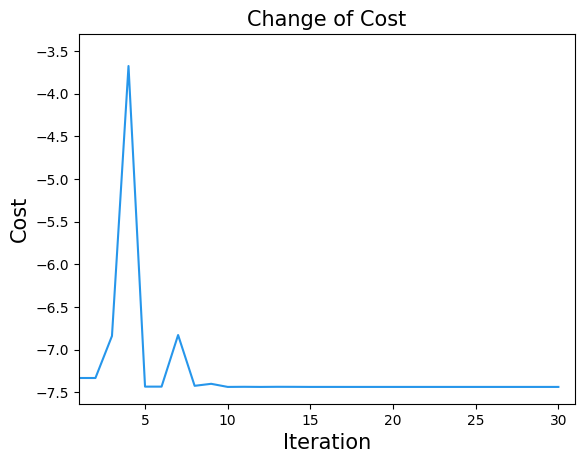

In [18]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [19]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)])
job_result = job.result()

In [20]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

### 解のプロット

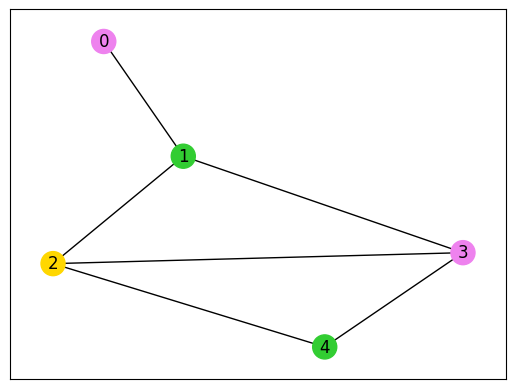

In [21]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.experimental.SampleSet):
    # 実行可能解を抽出する
    feasibles = sampleset.feasibles()
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.lowest()[0]

        # x = 1 のインデックスを取得する
        indices = lowest_sample.var_values["x"].values.keys()
        # 頂点と色を取得する  
        # 頂点の色リストを初期化する
        node_colors = [-1] * graph.number_of_nodes()
        # 可視化のための色リストを設定する 
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # 頂点の色リストを設定する  
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # 図を作成する
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

plot_graph_coloring(G, sampleset)

## Quri-Partsを用いた量子交互演算アンザッツの実行

In [28]:
# !pip install quri-parts-algo

In [ ]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
from quri_parts.core.state import quantum_state, apply_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

In [23]:
qp_transpiler = QuriPartsTranspiler()
qp_alternating_circuit = qp_transpiler.transpile_circuit(alternating_ansatz)
qp_cost = qp_transpiler.transpile_hamiltonian(qaoa_cost)

In [24]:
cb_state = quantum_state(alternating_ansatz.num_qubits, bits=0)
parametric_state = apply_circuit(qp_alternating_circuit, cb_state)

In [25]:
estimator = create_qulacs_vector_parametric_estimator()


cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_cost, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost


result = opt.minimize(cost_fn, [0, 0], method="COBYLA", options={"maxiter": 100})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.437499976499405
       x: [-1.831e-03  7.855e-01]
    nfev: 35
   maxcv: 0.0

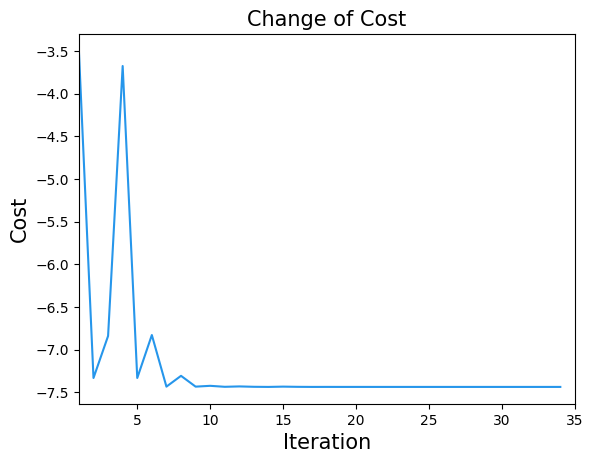

In [26]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [27]:
sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_alternating_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

In [28]:
sampleset = qaoa_converter.decode(qp_transpiler, (qp_result, alternating_ansatz.num_qubits))

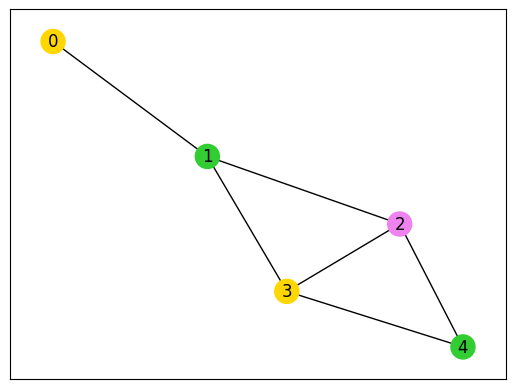

In [29]:
plot_graph_coloring(G, sampleset)

# References
[[1] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

[[2] Hadfield, Stuart, Zhihui Wang, Bryan O’gorman, Eleanor G. Rieffel, Davide Venturelli, and Rupak Biswas. "From the quantum approximate optimization algorithm to a quantum alternating operator ansatz." Algorithms 12, no. 2 (2019): 34.](https://arxiv.org/abs/1709.03489)